In [10]:
# Assuming you have a PreprocessMelanoma factory instance
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import init

from utils.dl import DLPipeline
from utils.loader import FactoryLoader
from utils.preprocessing import PreprocessingFactory

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
class SkinLesionCNN(nn.Module):
    # input images are 224x224
    def __init__(self):
        super(SkinLesionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=1)  # Binary classification

        # Apply Xavier initialization
        self._initialize_weights()

    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = F.leaky_relu_(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu_(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu_(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        # Fully connected layers
        x = F.leaky_relu_(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

In [6]:
# Dataset path
TRAIN_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\train"
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"

# Create preprocessing factory
factory = PreprocessingFactory()
factory.pad2square(fill=np.nan)  # Pad images to form square shape, filling with 0
factory.normalize2float()
factory.resize((224, 224))

# Create data loaders
PERCENT = 10
BATCH_SIZE = 32
train_loader = FactoryLoader(TRAIN_PATH, batch_size=BATCH_SIZE, factory=factory, percentage=PERCENT, shuffle=True)
val_loader = FactoryLoader(VAL_PATH, batch_size=BATCH_SIZE, factory=factory, percentage=PERCENT, shuffle=True)

In [7]:
# Create model, optimizer and loss function
model = SkinLesionCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Create pipeline
dl = DLPipeline(model, optimizer, criterion, train_loader, val_loader, "CustomCNN")

dl.save_path

'C:\\Users\\gimes\\Src\\repos\\CADx-Project\\2_DL\\Ch1\\runs\\12-02-21h37_CustomCNN'

In [8]:
# Train pipeline
dl.train(epochs=10)

INFO:utils.dl:[EPOCH] 1/10
INFO:utils.dl:[TRAIN] Batch 1/48
INFO:utils.dl:[TRAIN] Batch 11/48
INFO:utils.dl:[TRAIN] Batch 21/48
INFO:utils.dl:[TRAIN] Batch 31/48
INFO:utils.dl:[TRAIN] Batch 41/48
INFO:utils.dl:[TRAIN] Epoch 1/10 Loss: 0.6267994816104571
INFO:utils.dl:[VALIDATE] Batch 1/12
INFO:utils.dl:[VALIDATE] Batch 11/12
INFO:utils.dl:[VALIDATE] Epoch 1/10 Loss: 0.4449656729896863
INFO:utils.dl:[SAVE] Best model saved with loss: 0.4449656729896863
INFO:utils.dl:[EPOCH] 2/10
INFO:utils.dl:[TRAIN] Batch 1/48
INFO:utils.dl:[TRAIN] Batch 11/48
INFO:utils.dl:[TRAIN] Batch 21/48
INFO:utils.dl:[TRAIN] Batch 31/48
INFO:utils.dl:[TRAIN] Batch 41/48
INFO:utils.dl:[TRAIN] Epoch 2/10 Loss: 0.4527777296801408
INFO:utils.dl:[VALIDATE] Batch 1/12
INFO:utils.dl:[VALIDATE] Batch 11/12
INFO:utils.dl:[VALIDATE] Epoch 2/10 Loss: 0.43336542695760727
INFO:utils.dl:[SAVE] Best model saved with loss: 0.43336542695760727
INFO:utils.dl:[EPOCH] 3/10
INFO:utils.dl:[TRAIN] Batch 1/48
INFO:utils.dl:[TRAIN] Batc

              precision    recall  f1-score   support

     Class 0       0.96      0.86      0.91       189
     Class 1       0.88      0.96      0.92       189

    accuracy                           0.91       378
   macro avg       0.92      0.91      0.91       378
weighted avg       0.92      0.91      0.91       378



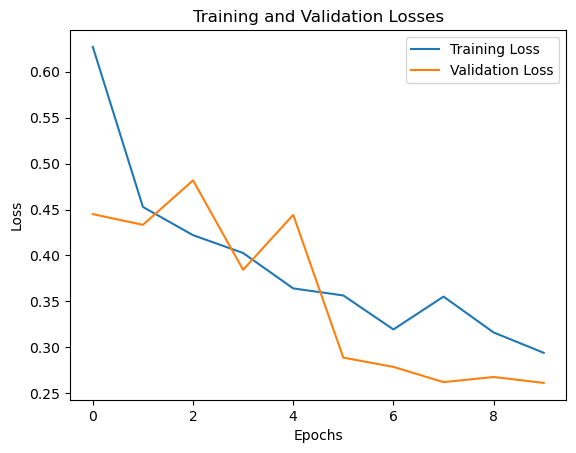

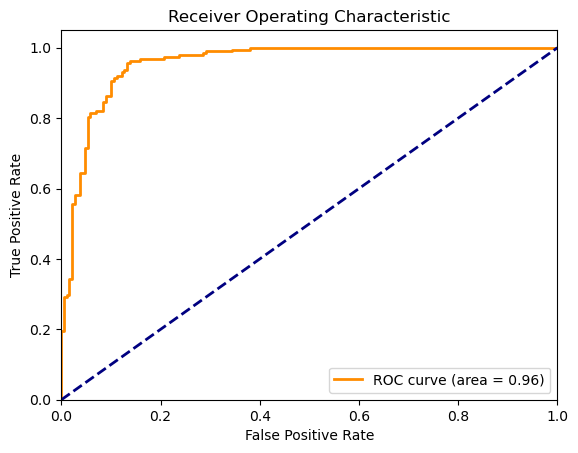

In [13]:
# Evaluate pipeline
report = dl.evaluate() 
print(report)

# Plot losses
dl.plot_losses()

# Plot Receiver Operating Characteristic (ROC) curve
dl.plot_roc_auc()